In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=48
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

45

(48, 256, 256, 3)
[0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 2 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0
 1 1 2 1 1 0 1 0 0 1 2]


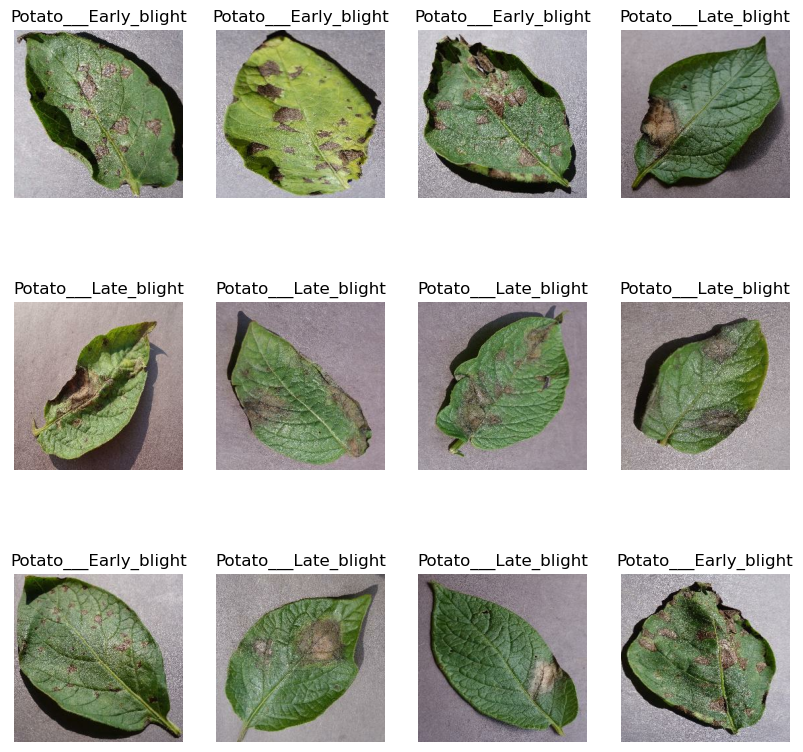

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

36 4 5


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (48, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (48, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (48, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (48, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (48, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (48, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
36/36 [==============================] - 75s 2s/step - loss: 0.9487 - accuracy: 0.4663 - val_loss: 0.8355 - val_accuracy: 0.5729
Epoch 2/20
36/36 [==============================] - 72s 2s/step - loss: 0.8668 - accuracy: 0.5087 - val_loss: 0.7204 - val_accuracy: 0.7135
Epoch 3/20
36/36 [==============================] - 72s 2s/step - loss: 0.6507 - accuracy: 0.7110 - val_loss: 0.5168 - val_accuracy: 0.7917
Epoch 4/20
36/36 [==============================] - 72s 2s/step - loss: 0.4716 - accuracy: 0.7919 - val_loss: 0.4023 - val_accuracy: 0.8073
Epoch 5/20
36/36 [==============================] - 72s 2s/step - loss: 0.3426 - accuracy: 0.8616 - val_loss: 0.3348 - val_accuracy: 0.8542
Epoch 6/20
36/36 [==============================] - 72s 2s/step - loss: 0.2764 - accuracy: 0.8913 - val_loss: 0.2844 - val_accuracy: 0.8698
Epoch 7/20
36/36 [==============================] - 75s 2s/step - loss: 0.2503 - accuracy: 0.9035 - val_loss: 0.2366 - val_accuracy: 0.9271
Epoch 8/20
36/36 [==

In [13]:
scores=model.evaluate(test_ds)
scores

5/5 [==============================] - 3s 355ms/step - loss: 0.7339 - accuracy: 0.8292


[0.733871340751648, 0.8291666507720947]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.9487156867980957,
 0.8668093681335449,
 0.6506608128547668,
 0.4715568423271179,
 0.3426050841808319,
 0.27643531560897827,
 0.2502739429473877,
 0.20527490973472595,
 0.25948333740234375,
 0.17989858984947205,
 0.12849225103855133,
 0.14782001078128815,
 0.10650941729545593,
 0.11493919044733047,
 0.10853991657495499,
 0.17164850234985352,
 0.09610947221517563,
 0.05862204357981682,
 0.0651799812912941,
 0.05633561685681343]

In [16]:
history.history['accuracy']

[0.4662790596485138,
 0.5087209343910217,
 0.7110465168952942,
 0.7918604612350464,
 0.8616279363632202,
 0.8912790417671204,
 0.9034883975982666,
 0.919767439365387,
 0.8924418687820435,
 0.9325581192970276,
 0.9482558369636536,
 0.9482558369636536,
 0.9581395387649536,
 0.9639534950256348,
 0.9587209224700928,
 0.934883713722229,
 0.9633721113204956,
 0.9779070019721985,
 0.9779070019721985,
 0.9790697693824768]

In [17]:
history.history['val_loss']

[0.835519015789032,
 0.7203842997550964,
 0.5167801380157471,
 0.40230438113212585,
 0.3347514867782593,
 0.2843656837940216,
 0.23663677275180817,
 0.4339785575866699,
 0.2782944142818451,
 0.19942831993103027,
 0.2782163619995117,
 0.1806824952363968,
 0.4424509108066559,
 0.41999712586402893,
 0.23890185356140137,
 0.32463642954826355,
 0.2762144207954407,
 0.23817138373851776,
 0.20205287635326385,
 0.6525780558586121]

In [18]:
history.history['val_accuracy']

[0.5729166865348816,
 0.7135416865348816,
 0.7916666865348816,
 0.8072916865348816,
 0.8541666865348816,
 0.8697916865348816,
 0.9270833134651184,
 0.8333333134651184,
 0.8802083134651184,
 0.8802083134651184,
 0.9270833134651184,
 0.9375,
 0.875,
 0.9010416865348816,
 0.9114583134651184,
 0.8958333134651184,
 0.9270833134651184,
 0.921875,
 0.9375,
 0.875]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

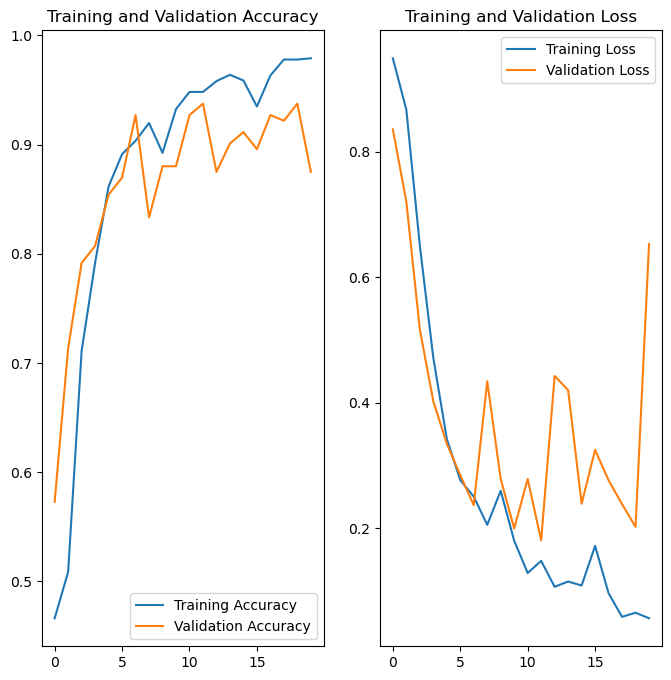

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [22]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(5):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

2/2 [==============================] - 0s 117ms/step


In [23]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


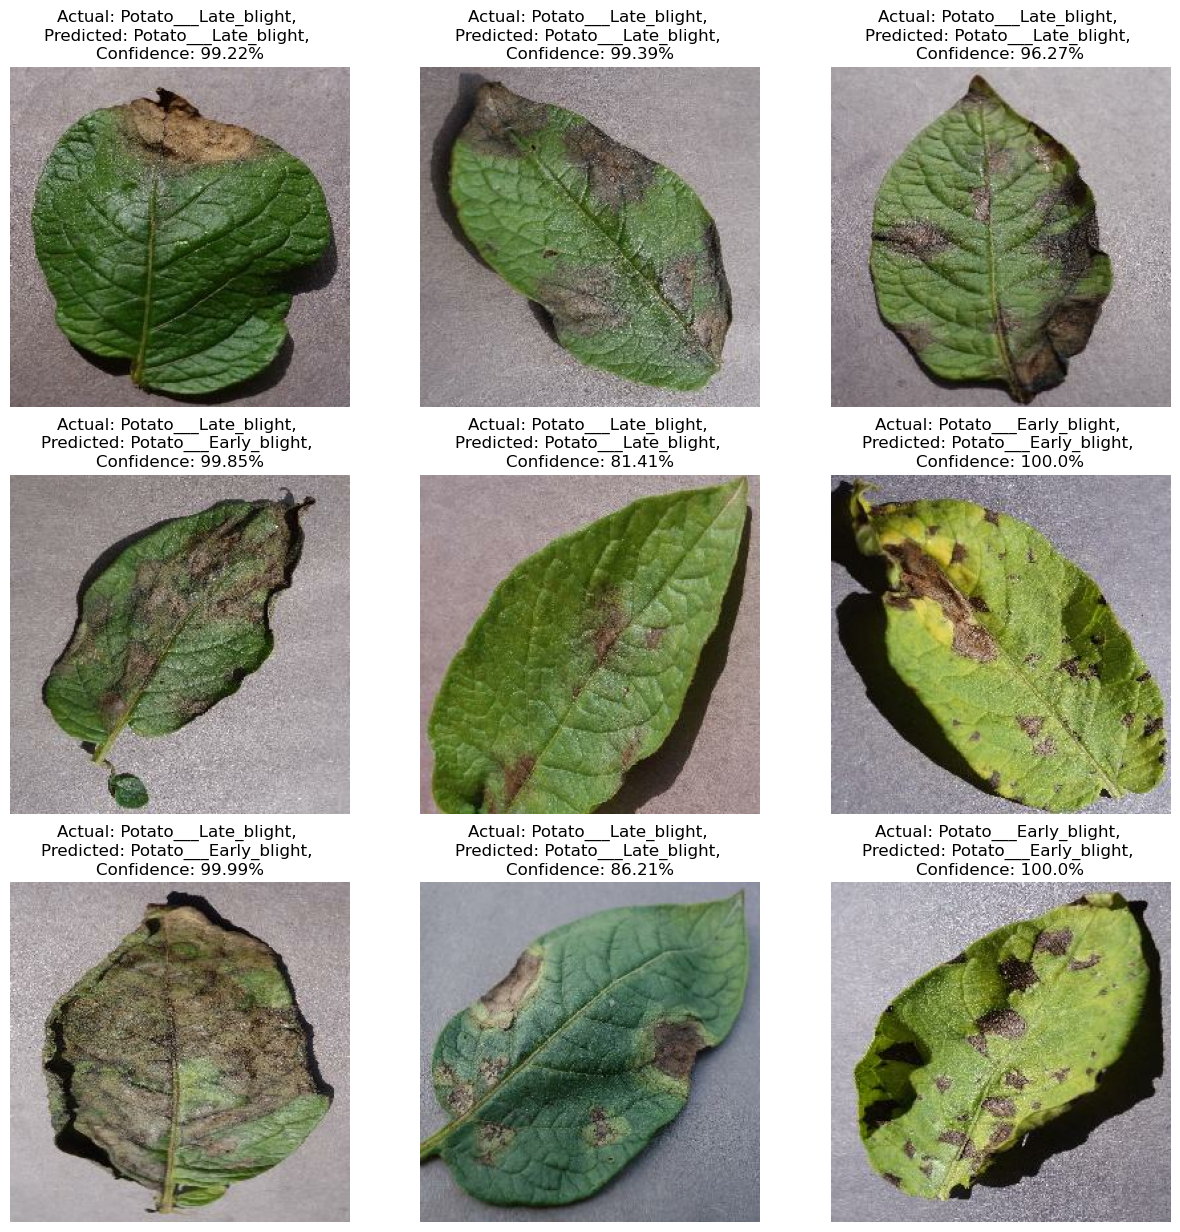

In [24]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [25]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.72      1.00      0.84       103
           1       1.00      0.66      0.80       122
           2       0.94      1.00      0.97        15

    accuracy                           0.83       240
   macro avg       0.89      0.89      0.87       240
weighted avg       0.88      0.83      0.83       240



In [26]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[103,   0,   0],
       [ 40,  81,   1],
       [  0,   0,  15]])>

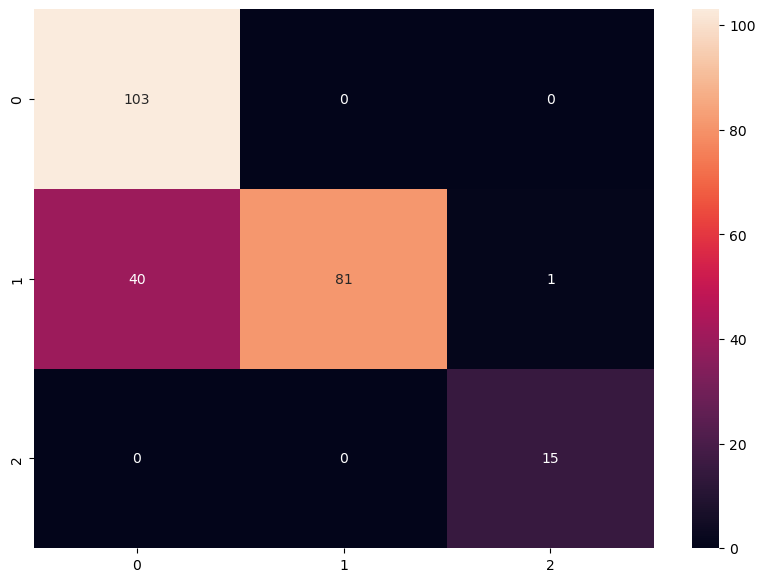

In [27]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [28]:
filename = "Model1-BatchSize48.joblib"
joblib.dump(model, filename)

['Model1-BatchSize48.joblib']